**GRUPO**



Higor Vinicios Carrião RA:1903471

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("/content/Case_cobranca - Case_cobranca.csv")

In [3]:
df

,COD,TIPO_CLIENTE,TIPO_EMPRESTIMO,CD_SEXO,IDADE,QTD_DIVIDAS,TEMP_RECUPERACAO
0,1,NOVO,CDC,M,26.0,0,227.0
1,2,NOVO,RENEGOCIAÇÃO,M,39.0,0,37.0
2,3,NOVO,PESSOAL,M,31.0,1,NaN
3,4,NOVO,PESSOAL,F,45.0,11,NaN
4,5,NOVO,CDC,F,25.0,0,8.0
...,...,...,...,...,...,...,...
9812,9813,NOVO,CDC,F,38.0,1,23.0
9813,9814,NOVO,RENEGOCIAÇÃO,M,34.0,2,234.0
9814,9815,TOMADOR,CDC,NaN,30.0,4,13.0
9815,9816,INVESTIDOR,CDC,M,43.0,0,6.0


# Entendimento do negócio

* Qual a empresa?
  * Vingadores Recuperação de Ativos Ltda.
* Qual a área de atuação?
  * Titulos Vencidos de um banco
* Qual o problema de negócio que será resolvido?
  * A empresa Vingadores atualmente não utiliza nenhum tipo de ordenação baseada em
Data Science para orientar a priorização das chamadas de seus atendentes de call
Center que realizam a cobrança 
* Quais os objetivos?
  * identificar e ordenar os bons e maus pagadores
* Quais tarefas serão utilizadas?
  * KNN, Arvore de Decisão e Regressão Logistica
* Quais os critérios de sucesso?
  * Bons pagadores: TEMP_RECUPERACAO <=90 e Maus pagadores: TEMP_RECUPERACAO > 90 ou vazio
* Faça um descritivo da solução
  * vamos organizar em order de prioridade de cobrança os devedores que tem a maior chance de pagar a divida

# Entendimento dos dados

* **Qual o formato dos dados?**

In [ ]:
df.dtypes

COD                   int64
TIPO_CLIENTE         object
TIPO_EMPRESTIMO      object
CD_SEXO              object
IDADE               float64
QTD_DIVIDAS           int64
TEMP_RECUPERACAO    float64
dtype: object

* **Quantos registros existem?**

In [ ]:
df.shape

(9817, 7)

* **Quais os campos? Coloque uma descrição de cada um deles. Utilize o arquivo de de dicionário
de dados disponibilizado**

In [ ]:
df.columns

Index(['COD', 'TIPO_CLIENTE', 'TIPO_EMPRESTIMO', 'CD_SEXO', 'IDADE',
       'QTD_DIVIDAS', 'TEMP_RECUPERACAO'],
      dtype='object')

* 'COD' = Código da dívida 
* 'TIPO_CLIENTE' = Classificação do cliente (NOVO, INVESTIDOR e TOMADOR)
* 'TIPO_EMPRESTIMO' = Tipo do empréstimo (CDC, PESSOAL e RENEGOCIAÇÃO)
* 'CD_SEXO' = Sexo do cliente
* 'IDADE' = Idade do cliente
* 'QTD_DIVIDAS' = Quantidade de outras dívidas
- 'TEMP_RECUPERACAO' = Tempo para quitação da dívida em dias (nulo se não pagou)

* **Qual campo é um candidato a alvo?**

'TEMP_RECUPERACAO'

* **Quantos vazios existem em cada atributo?**


In [ ]:
df.isnull().sum()

COD                    0
TIPO_CLIENTE          24
TIPO_EMPRESTIMO        0
CD_SEXO              837
IDADE               1002
QTD_DIVIDAS            0
TEMP_RECUPERACAO    4285
dtype: int64

* **Qual a distribuição de maus pagadores e bons pagadores?**
  * Bons pagadores: TEMP_RECUPERACAO <=90
  * Maus pagadores: TEMP_RECUPERACAO > 90 ou vazio 


* **Qual a distribuição das idades (histograma)**


FileNotFoundError: ignored

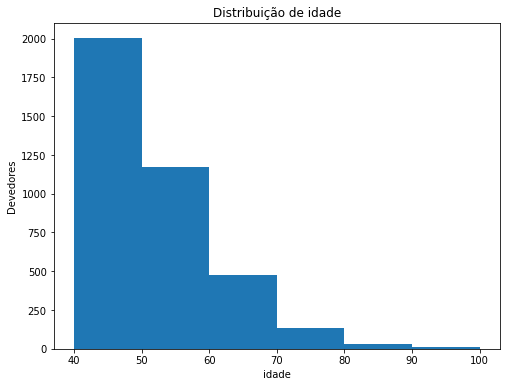

In [ ]:
Idade = df['IDADE']

plt.figure(figsize=(8, 6))
plt.hist(Idade, bins=range(40, 110,10))
plt.title('Distribuição de idade')
plt.xlabel('idade')
plt.ylabel('Devedores')
plt.savefig('imagens/peso-histograma.png')
plt.close()

* Quais os tipos de empréstimo? Utilize algum gráfico de visualização

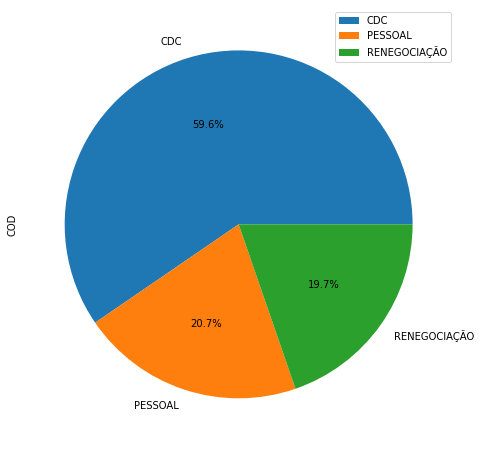

In [ ]:
grupo = df.groupby(by='TIPO_EMPRESTIMO').count()
pizza = grupo[['COD']].plot(y='COD',  kind='pie', autopct='%1.1f%%', figsize=(20,8))

# Preparação dos dados


* **Crie um atributo ALVO**
    * Bons pagadores: TEMP_RECUPERACAO <=90 → 1
    * Maus pagadores: TEMP_RECUPERACAO > 90 ou vazio → 0


In [4]:
df['BOM_PAGADOR'] = df['TEMP_RECUPERACAO'].apply(lambda x: '1' if x <= 90 else '0')
df[['BOM_PAGADOR', 'TEMP_RECUPERACAO']]

,BOM_PAGADOR,TEMP_RECUPERACAO
0,0,227.0
1,1,37.0
2,0,NaN
3,0,NaN
4,1,8.0
...,...,...
9812,1,23.0
9813,0,234.0
9814,1,13.0
9815,1,6.0


*  **Faça a codificação da coluna TIPO_CLIENTE para criar duas novas colunas**
    * CLIENTE_NOVO: 1 se TIPO_CLIENTE == NOVO, 0 caso contrário
    * CLIENTE_INVESTIDOR: 1 se TIPO_CLIENTE == INVESTIDOR, 0 caso contrário

In [5]:
df['CLIENTE_NOVO'] = df['TIPO_CLIENTE'].apply(lambda x: '1' if x == 'NOVO' else '0')
df[['CLIENTE_NOVO', 'TIPO_CLIENTE']]

,CLIENTE_NOVO,TIPO_CLIENTE
0,1,NOVO
1,1,NOVO
2,1,NOVO
3,1,NOVO
4,1,NOVO
...,...,...
9812,1,NOVO
9813,1,NOVO
9814,0,TOMADOR
9815,0,INVESTIDOR


In [6]:
df['CLIENTE_INVESTIDOR'] = df['TIPO_CLIENTE'].apply(lambda x: '1' if x == 'INVESTIDOR' else '0')
df[['CLIENTE_INVESTIDOR', 'TIPO_CLIENTE']]

,CLIENTE_INVESTIDOR,TIPO_CLIENTE
0,0,NOVO
1,0,NOVO
2,0,NOVO
3,0,NOVO
4,0,NOVO
...,...,...
9812,0,NOVO
9813,0,NOVO
9814,0,TOMADOR
9815,1,INVESTIDOR


* **Faça a codificação da coluna TIPO_EMPRESTIMO para criar duas novas colunas**
    * EMPRESTIMO_CDC: 1 se TIPO_EMPRESTIMO == CDC, 0 caso contrário
    * EMPRESTIMO_PESSOAL: 1 se TIPO_ EMPRESTIMO == PESSOAL, 0 caso contrário

In [7]:
df['EMPRESTIMO_CDC'] = df['TIPO_EMPRESTIMO'].apply(lambda x: '1' if x == 'CDC' else '0')
df[['EMPRESTIMO_CDC', 'TIPO_EMPRESTIMO']]

,EMPRESTIMO_CDC,TIPO_EMPRESTIMO
0,1,CDC
1,0,RENEGOCIAÇÃO
2,0,PESSOAL
3,0,PESSOAL
4,1,CDC
...,...,...
9812,1,CDC
9813,0,RENEGOCIAÇÃO
9814,1,CDC
9815,1,CDC


In [8]:
df['EMPRESTIMO_PESSOAL'] = df['TIPO_EMPRESTIMO'].apply(lambda x: '1' if x == 'PESSOAL' else '0')
df[['EMPRESTIMO_PESSOAL','TIPO_EMPRESTIMO']]

,EMPRESTIMO_PESSOAL,TIPO_EMPRESTIMO
0,0,CDC
1,0,RENEGOCIAÇÃO
2,1,PESSOAL
3,1,PESSOAL
4,0,CDC
...,...,...
9812,0,CDC
9813,0,RENEGOCIAÇÃO
9814,0,CDC
9815,0,CDC


# Preparação dos dados (continuação)

* **Faça a codificação da coluna CD_SEXO para criar uma nova coluna SEXO_M:**
    * 1 se CD_SEXO == M, 0 caso contrário

In [9]:
df['SEXO_M'] = df['CD_SEXO'].apply(lambda x: '1' if x == 'M' else '0')
df[['SEXO_M', 'CD_SEXO']]

,SEXO_M,CD_SEXO
0,1,M
1,1,M
2,1,M
3,0,F
4,0,F
...,...,...
9812,0,F
9813,1,M
9814,0,NaN
9815,1,M


* Considere as idades vazias e menores que 18 anos como sendo 18 anos


In [10]:
# df['IDADE'] = df['IDADE'].apply(lambda x: 18 if x < 18 or x.isna() else x)

In [11]:
df["IDADE"].fillna(18, inplace = True)
df["IDADE"].isnull().sum()

0

In [12]:
df['IDADE'].loc[df.IDADE<18]=18

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
df['IDADE'].loc[df.IDADE==18]

13      18.0
21      18.0
23      18.0
60      18.0
62      18.0
        ... 
9763    18.0
9765    18.0
9776    18.0
9797    18.0
9799    18.0
Name: IDADE, Length: 1015, dtype: float64

* Considere as idades maiores que 76 anos como sendo 76 anos


In [14]:
df['IDADE'] = df['IDADE'].apply(lambda x: 76 if x > 76 else x)
df['IDADE'].loc[df.IDADE>76]

Series([], Name: IDADE, dtype: float64)

* Normalize a idade com a seguinte fórmula:
* (IDADE-18)/(76-18)

In [15]:
df['IDADE'] = ((df['IDADE']-18)/(76-18))

* **Normalize a quantidade de dívidas com a seguinte fórmula:**
    * QTD_DIVIDAS/16
    * Vazio: 0

In [16]:
df['QTD_DIVIDAS'] = (df['QTD_DIVIDAS']/16)

# KNN

In [17]:
X = df.drop(['COD', 'TIPO_CLIENTE', 'TIPO_EMPRESTIMO', 'CD_SEXO', 'TEMP_RECUPERACAO', 'BOM_PAGADOR'], axis=1)
y = df['BOM_PAGADOR']

**Dividir em Treino e Teste**

In [18]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [19]:
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((7362, 7), (2455, 7), (7362,), (2455,))

In [20]:
parametros = {'n_neighbors': [i for i in range(1, 20)]}
busca = GridSearchCV(KNeighborsClassifier(), parametros, scoring='accuracy')
busca.fit(X_treino, y_treino)
print('Melhor estimador (modelo)')
busca.best_estimator_

Melhor estimador (modelo)


KNeighborsClassifier(n_neighbors=11)

In [21]:
y_pred = busca.predict(X_teste)
round(accuracy_score(y_teste, y_pred), 2)

0.73

**Matriz de Confusão**

In [22]:
cm = confusion_matrix(y_teste, y_pred)
cm

array([[ 788,  384],
       [ 283, 1000]])

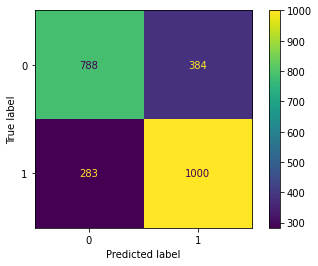

In [23]:
ConfusionMatrixDisplay(cm).plot();

# Arvore de Decisão

In [24]:
modelo = DecisionTreeClassifier(random_state=0)
modelo.fit(X_treino, y_treino)

DecisionTreeClassifier(random_state=0)

In [25]:
y_pred = modelo.predict(X_teste)
accuracy_score(y_teste, y_pred)

0.7380855397148676

In [26]:
cm2 = confusion_matrix(y_teste, y_pred)
cm2

array([[869, 303],
       [340, 943]])

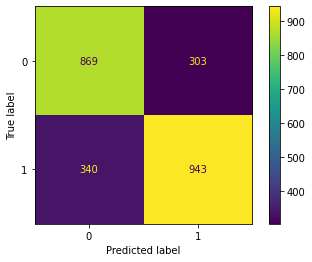

In [27]:
ConfusionMatrixDisplay(cm2).plot();

# Regressão Logistica

In [28]:
logit = LogisticRegression()

In [29]:
logit.fit(X_treino, y_treino)

LogisticRegression()

In [30]:
y_pred = logit.predict(X_teste)

In [31]:
logit.score(X_teste, y_teste)

0.734826883910387

In [32]:
cm3 = confusion_matrix(y_teste, y_pred)
cm3

array([[ 732,  440],
       [ 211, 1072]])

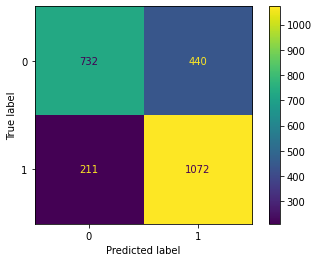

In [33]:
ConfusionMatrixDisplay(cm3).plot();

# Implantação

In [34]:
import pickle

In [35]:
data = [[0, 0.2500, 1, 0, 0, 0, 1]]

In [36]:
s = pickle.dumps(logit)

In [37]:
clf2 = pickle.loads(s)

In [38]:
clf2.predict(data[0:1])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array(['0'], dtype=object)

**Mau pagador**